# CROP-seq KO150 - Mixscape analysis of each condition separately
- input: filtered seurat object
- output: real perturbed cells, LDA UMAP plot,...

In [1]:
# set correct working directory -> project folder
getwd()
setwd('..')
getwd()

[1] "/home/sreichl/projects/bmdm-stim/src"

[1] "/home/sreichl/projects/bmdm-stim"

In [2]:
# load libraries
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(dplyr)
library(reshape2)
library(stringr)
library(ggrepel)


# Setup custom theme for plotting.
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# configs
data_path <- file.path('results','KO150')

fine_mode <- FALSE
# fine_mode <- TRUE

if (fine_mode){
    mixscape_dir = "mixscape_finemode"
} else{
    mixscape_dir = "mixscape"
}

# cond <- 'untreated'
# cond <- 'LO28-6h'
cond <- 'LO28-24h'

results_path <- file.path(data_path, mixscape_dir, cond)

In [4]:
# make directories if not exist
dir.create(results_path, showWarnings = FALSE, recursive = TRUE)

# load filtered Seurat object

In [5]:
# loading Seurat object
KO150 <-readRDS(file = file.path(data_path,paste0("KO150_filtered_Seurat.rds")))
KO150

An object of class Seurat 
31673 features across 28303 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

## prepare metadata

In [6]:
KO150[['condition']] <- str_split_fixed(KO150$hto_demux, "_", 2)[,2]

In [7]:
KO150$KO_call[KO150$KO_call=='NonTargeting-'] <- 'NonTargeting'

# filter for condition 

In [8]:
# filter by condition
KO150 <- subset(KO150, subset = condition == cond)
KO150

An object of class Seurat 
31673 features across 4549 samples within 4 assays 
Active assay: gRNA (600 features, 0 variable features)
 3 other assays present: RNA, AB, HTO

In [9]:
unique(KO150$condition)

[1] "LO28-24h"

# prepare seurat object for mixscape analysis
ie create new columns, named accoring to example data of vignette

In [10]:
# column gene
KO150[["gene"]] <- KO150$KO_call
KO150$gene[KO150$gene=="NonTargeting"] <- 'NT'

In [11]:
# column NT
KO150[["NT"]] <- str_replace(KO150$guide_call, '-', 'g')
KO150$NT[grep("^NonTargeting",KO150$NT)] <- 'NT'

In [12]:
# column crispr for distinguishing perturbed & non-perturbed cells
KO150[["crispr"]] <- KO150$gene
KO150$crispr[KO150$crispr!="NT"] <- "Perturbed"

In [13]:
KO150[[c("gene","NT","crispr")]][1:40,]

,gene,NT,crispr
,<chr>,<chr>,<chr>
C1_AAACCTGAGGGATCTG-1,Dek,Dekg1,Perturbed
C1_AAACCTGGTGTAAGTA-1,Stat1,Stat1g3,Perturbed
C1_AAACGGGCATAGTAAG-1,Stat2,Stat2g2,Perturbed
C1_AAACGGGTCGGCGGTT-1,Med8,Med8g3,Perturbed
C1_AAACGGGTCGGTTCGG-1,Sf3b1,Sf3b1g4,Perturbed
C1_AAAGATGAGGATATAC-1,Pkm,Pkmg1,Perturbed
C1_AAAGATGAGGTCGGAT-1,Ppm1g,Ppm1gg1,Perturbed
C1_AAAGATGTCTCAAACG-1,Hdgf,Hdgfg2,Perturbed
C1_AAAGCAACAGCCTATA-1,Baz1a,Baz1ag2,Perturbed


# Mixscape

In [14]:
# Normalize protein.
KO150 <- NormalizeData(
  object = KO150, 
  assay = "AB", 
  normalization.method = "CLR", 
  margin = 2)

Normalizing across cells



In [15]:
# Prepare RNA assay for dimensionality reduction: 
# Normalize data, find variable features and scale data.
DefaultAssay(object = KO150) <- 'RNA'
KO150 <- NormalizeData(object = KO150) %>% FindVariableFeatures() %>% ScaleData()

# Run Principle Component Analysis (PCA) to reduce the dimensionality of the data.
KO150 <- RunPCA(object = KO150)

# Run Uniform Manifold Approximation and Projection (UMAP) to visualize clustering in 2-D.
KO150 <- RunUMAP(object = KO150, dims = 1:40)

Centering and scaling data matrix

PC_ 1 
Positive:  Hilpda, Procr, Lgals3, Cd274, Dusp5, Smox, Dusp1, Vegfa, Cd14, Slfn4 
	   Csf3, Mxd1, Cebpb, Mcl1, Grina, Cd300lf, Slc2a1, Lrpap1, Pmp22, Clec4e 
	   Plin2, Isg15, Csrnp1, Zfp36, Sdc3, Wfdc17, Ccrl2, Prr13, Ccl2, Cxcl2 
Negative:  Pclaf, Birc5, Ccna2, Cks1b, Smc2, Rrm1, Top2a, Asf1b, Stmn1, Ccnb1 
	   Cdca8, Rrm2, Aurkb, Mki67, Pbk, Ccnb2, Mcm3, Tacc3, Tpx2, Cdca3 
	   Racgap1, Smc4, Ube2c, Rfc4, Cenpf, Ska1, Tipin, Ckap2l, H2afz, Cdk1 
PC_ 2 
Positive:  Cd47, St3gal6, Lix1, Rassf4, Ptpn6, Cct8, Hck, Nfkbiz, Irf8, Vav1 
	   Ms4a6c, Pdia6, Pim2, Fcgr2b, Lcn2, Ifngr2, Pou2f2, Ms4a6d, Serp1, Urah 
	   Cdk2ap2, Usp18, Cp, Ctsc, Limd2, Ebi3, Samsn1, P4hb, Sp110, Hsp90b1 
Negative:  Gpnmb, Hilpda, Dusp5, Ier5, Ttc9, Fxyd2, Dusp4, Fos, Pmepa1, Osm 
	   Adssl1, Pmp22, Vegfa, Gpr137b, Ifi27, S100a10, Cipc, Mcl1, Cxcl2, Slc37a2 
	   Lims2, Gprc5a, Trem2, Cd9, Cystm1, Nr4a1, Actn1, Fosl2, Irf2bpl, Errfi1 
PC_ 3 
Positive:  Fcgr1, Fcgr4, Phf11d,

In [16]:
mouseHumanGenes <- read.table(file = file.path("resources","HOM_MouseHumanSequence.rpt"), sep = '\t', header = TRUE)

In [17]:
# convert human cell cycle genes to murine genes
m.g2m.genes <- vector()

for (human_gene in cc.genes$g2m.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.g2m.genes <- append(m.g2m.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.g2m.genes

In [18]:
# convert human cell cycle genes to murine genes
m.s.genes <- vector()

for (human_gene in cc.genes$s.genes){
    tmp_homolo_ID <- mouseHumanGenes[mouseHumanGenes$Symbol==human_gene,'HomoloGene.ID']
    m.s.genes <- append(m.s.genes, mouseHumanGenes[mouseHumanGenes$HomoloGene.ID==tmp_homolo_ID & mouseHumanGenes$Common.Organism.Name=="mouse, laboratory", "Symbol"])
}

# m.s.genes

In [19]:
# determine cell cycle scores
s.genes <- m.s.genes
g2m.genes <- m.g2m.genes
KO150 <- CellCycleScoring(KO150, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

In [20]:
DefaultAssay(object = KO150) <- 'RNA'

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



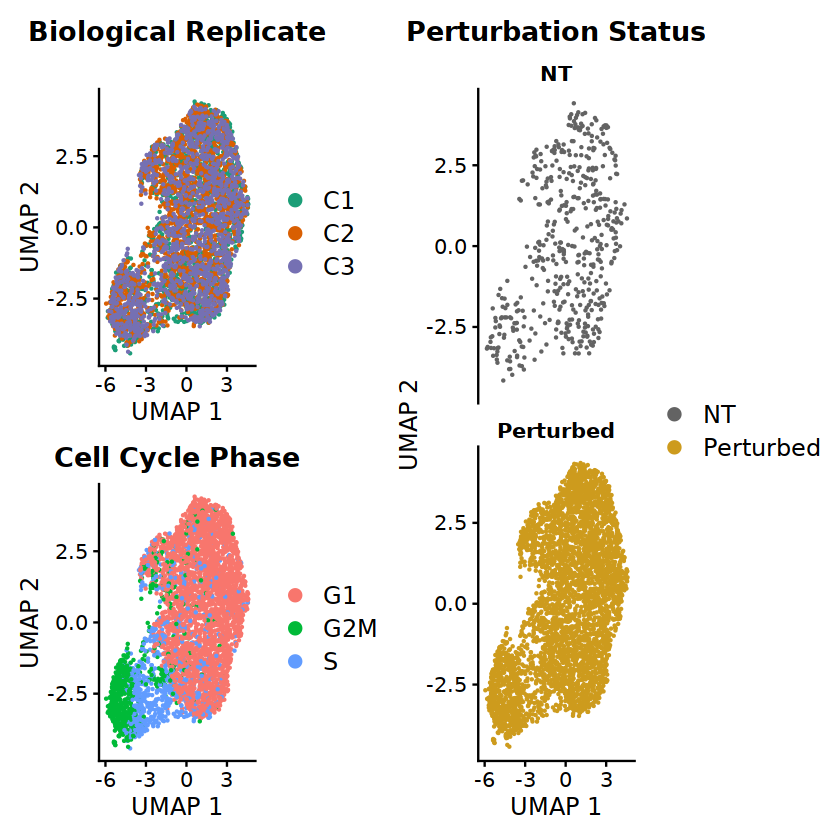

In [21]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
p1 <- DimPlot(
  object = KO150, 
  group.by = 'batch', 
  label = F, 
  pt.size = 0.2, 
  reduction = "umap", cols = "Dark2", repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  xlab("UMAP 1") +
  ylab("UMAP 2") +
  custom_theme

p2 <- DimPlot(
  object = KO150, 
  group.by = 'Phase', 
  label = F, pt.size = 0.2, 
  reduction = "umap", repel = T) + 
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

p3 <- DimPlot(
  object = KO150, 
  group.by = 'crispr', 
  pt.size = 0.2, 
  reduction = "umap", 
  split.by = "crispr", 
  ncol = 1, 
  cols = c("grey39","goldenrod3")) + 
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
((p1 / p2 + plot_layout(guides = 'auto')) | p3 )
# ((p1 / p1 + plot_layout(guides = 'auto')) | p3 )

ggsave(
  paste0("KO150_","_UMAP_prePerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [22]:
# Calculate perturbation signature (PRTB).
KO150 <- CalcPerturbSig(
  object = KO150, 
  assay = "RNA", 
  slot = "data", 
  gd.class ="gene", 
  nt.cell.class = "NT", 
  reduction = "pca", 
  ndims = 40, 
  num.neighbors = 30, 
#   split.by = "replicate", 
  new.assay.name = "PRTB")

Processing rep1



In [23]:
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = KO150) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = KO150) <- VariableFeatures(object = KO150[["RNA"]])
KO150 <- ScaleData(object = KO150, do.scale = F, do.center = T)

# Run PCA to reduce the dimensionality of the data.
KO150 <- RunPCA(object = KO150, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
KO150 <- RunUMAP(
  object = KO150, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Centering data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Gm42418, Txnip, Lars2, Hist1h1c, Snhg20, Gclc, Ahnak, Hist1h1e, Cytip, Gm26917 
	   Bhlhe40, Icam1, Cd83, mt-Cytb, Tspan13, Spata7, Lsp1, Tnfrsf9, Nop10, Ccnd2 
	   Slpi, S100a4, Scd2, Txnrd1, Pnrc1, S100a11, AC127341.3, Ckb, 2810474O19Rik, Ccl6 
Negative:  Ccl2, Csf3, Ccl4, Cxcl2, Ptgs2, Acod1, Oasl1, Ccl5, Wfdc17, Spp1 
	   Ccl9, Isg15, Tnf, Rsad2, Phlda1, Lcn2, Cd14, Socs3, Ier3, Ifit2 
	   Ccl7, Il1rn, Atf3, Il1a, Slfn4, Odc1, Zfp36, Il1b, Clec4e, Hilpda 
prtbpca_ 2 
Positive:  Cxcl2, Csf3, Ccl2, Spp1, Ccl7, Ier3, Mt1, Odc1, Phlda1, Hmox1 
	   Mt2, Cebpb, S100a6, Clec4e, Vim, Plaur, Hmga2, Clec4d, Glrx, Ptgs2 
	   Alox5ap, Lyz2, Hilpda, Tmsb4x, Ctsl, Gm5483, Ccnd1, Cd9, Cited2, 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



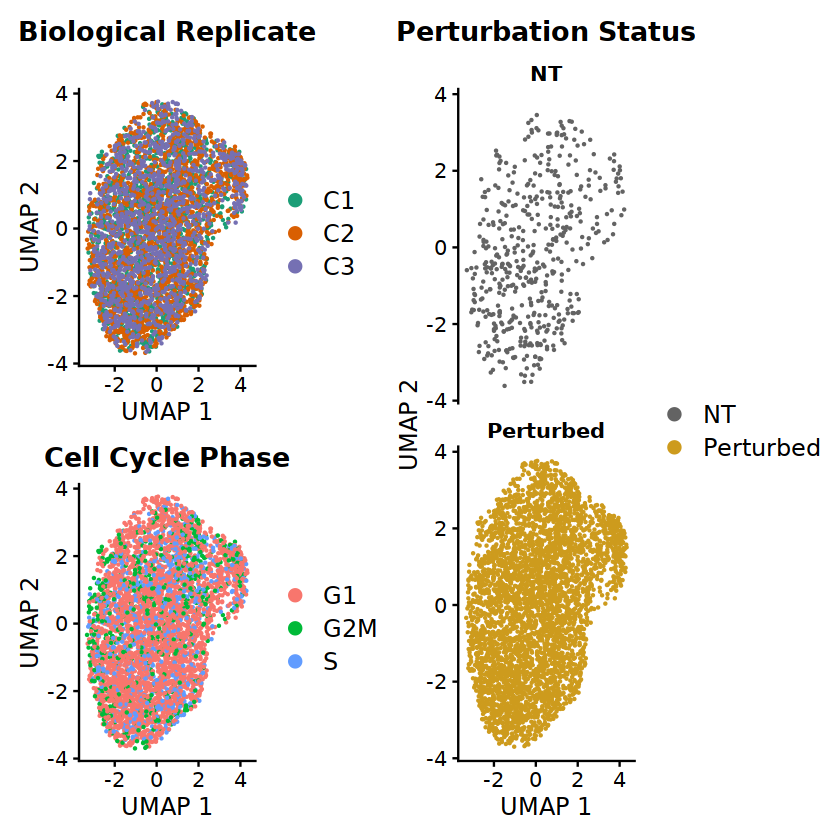

In [24]:
# Generate plots to check if clustering is driven by biological replicate ID, 
# cell cycle phase or target gene class.
q1 <- DimPlot(
  object = KO150, 
  group.by = 'batch', 
  reduction = 'prtbumap', 
  pt.size = 0.2, cols = "Dark2", label = F, repel = T) +
  scale_color_brewer(palette = "Dark2") +
  ggtitle("Biological Replicate") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

q2 <- DimPlot(
  object = KO150, 
  group.by = 'Phase', 
  reduction = 'prtbumap', 
  pt.size = 0.2, label = F, repel = T) +
  ggtitle("Cell Cycle Phase") +
  ylab("UMAP 2") +
  xlab("UMAP 1") + 
  custom_theme

q3 <- DimPlot(
  object = KO150,
  group.by = 'crispr',
  reduction = 'prtbumap', 
  split.by = "crispr", 
  ncol = 1, 
  pt.size = 0.2, 
  cols = c("grey39","goldenrod3")) +
  ggtitle("Perturbation Status") +
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme

# Visualize plots.
(q1 / q2 + plot_layout(guides = 'auto') | q3)
# (q1 / q1 + plot_layout(guides = 'auto') | q3)

ggsave(
  paste0("KO150_","_UMAP_postPerturbScore",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [25]:
# Run mixscape.
KO150 <- RunMixscape(
  object = KO150, 
  assay = "PRTB", 
  slot = "scale.data", 
  labels = "gene", 
  nt.class.name = "NT", 
  min.de.genes = 5, # default 5
  iter.num = 10, 
  de.assay = "RNA", 
  verbose = F,
    fine.mode = fine_mode,
  fine.mode.labels = "NT",
  prtb.type = "KO",
    logfc.threshold = 0.1 # default 0.25
)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

number of iterations= 22 
number of iterations= 40 
number of iterations= 27 
number of iterations= 15 
number of iterations= 12 
number of iterations= 50 
number of iterations= 45 
number of iterations= 13 
number of iterations= 8 
number of iterations= 127 
number of iterations= 32 
number of iterations= 32 
number of iterations= 20 
number of iterations= 14 
number of iterations= 21 
number of iterations= 10 
number of iterations= 16 
number of iterations= 15 
number of iterations= 37 
number of iterations= 36 
number of iterations= 16 
number of iterations= 16 
number of iterations= 36 
number of iterations= 28 
number of iterations= 27 


In [26]:
# save Seurat object
saveRDS(KO150, file = file.path(results_path,paste0("KO150_mixscape_Seurat.rds")))

In [4]:
# loading Seurat object
KO150 <- readRDS(file = file.path(results_path,paste0("KO150_mixscape_Seurat.rds")))
KO150

An object of class Seurat 
33838 features across 4549 samples within 5 assays 
Active assay: PRTB (2165 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [5]:
# save matrix of PRTB counts
PRTB <- GetAssayData(object = KO150, slot = "data")
dim(PRTB)
head(PRTB)
write.csv(PRTB, file=file.path(results_path,paste0('KO150_mixscape_PRTB','.csv')), row.names=TRUE)

[1] 2165 4549

,C1_AAACCTGAGGGATCTG-1,C1_AAACCTGGTGTAAGTA-1,C1_AAACGGGCATAGTAAG-1,C1_AAACGGGTCGGCGGTT-1,C1_AAACGGGTCGGTTCGG-1,C1_AAAGATGAGGATATAC-1,C1_AAAGATGAGGTCGGAT-1,C1_AAAGATGTCTCAAACG-1,C1_AAAGCAACAGCCTATA-1,C1_AAAGTAGAGTGTCCAT-1,⋯,C3_TTTGCGCTCAAACCGT-1,C3_TTTGCGCTCACCAGGC-1,C3_TTTGCGCTCCAGAAGG-1,C3_TTTGGTTAGCCGATTT-1,C3_TTTGGTTAGTGAAGAG-1,C3_TTTGGTTCACCGATAT-1,C3_TTTGGTTGTCAGATAA-1,C3_TTTGGTTGTCGCTTTC-1,C3_TTTGGTTGTTCCATGA-1,C3_TTTGTCATCGCCCTTA-1
Cxcl3,0.009809001,0.020452128,0.255018928,0.07663098,0.62879320,1.75952964,0.02781655,0.009809001,0.41247472,0.21248727,⋯,0.066358444,0.08797776,0.114075213,-0.51784202,-0.9938939,0.01508279,0.27005427,2.4014516,0.657270259,0.06733913
S100a8,0.100612638,-0.085940871,1.717153007,1.67661221,0.73035738,0.31953178,1.11759905,0.245517380,0.67681035,0.80443581,⋯,0.572682173,0.11740930,0.218472357,1.19634855,0.1820652,0.28638379,-2.86037793,0.2880022,0.760813360,1.67207712
Csf2,0.459411062,0.007552849,0.019843496,0.25546436,0.02903001,0.96024431,0.25520273,0.676118780,0.18363151,0.18215795,⋯,-0.804522588,0.57043637,0.557333520,0.20767283,0.4180482,0.15700390,0.40077941,0.0000000,0.072074179,0.23645922
U90926,0.012452763,-0.071346335,0.196965344,0.19696534,0.00000000,0.52487123,0.20827677,0.064132280,0.05734201,0.04547271,⋯,0.006685992,0.05566830,0.007738539,0.24955683,0.6674372,0.06410781,0.21540400,0.6491742,0.000000000,-0.19288500
Hamp,0.020290874,0.000000000,0.007033466,0.00000000,0.03925517,0.06055302,0.00000000,0.014367031,0.02162184,0.00000000,⋯,0.127629698,0.00000000,0.027289160,0.07648384,-1.4252851,0.07323702,0.07658437,0.0000000,0.007033466,0.04665175
Ccl22,0.047277780,0.006946547,0.100270922,0.10062094,0.03118459,0.03939859,0.02682638,0.158363774,-0.35826085,0.03570967,⋯,0.093307351,0.11915341,0.079333947,0.04266087,-3.6718269,0.54386412,0.04072541,-0.7926273,0.025728883,0.08362513


In [27]:
# save mixscape annotation data
write.csv(
    KO150[[c('mixscape_class', 'mixscape_class_p_ko', 'mixscape_class.global')]],
    file = file.path(results_path,paste0("KO150_mixscape_annotations.csv")),
    row.names=TRUE
    )

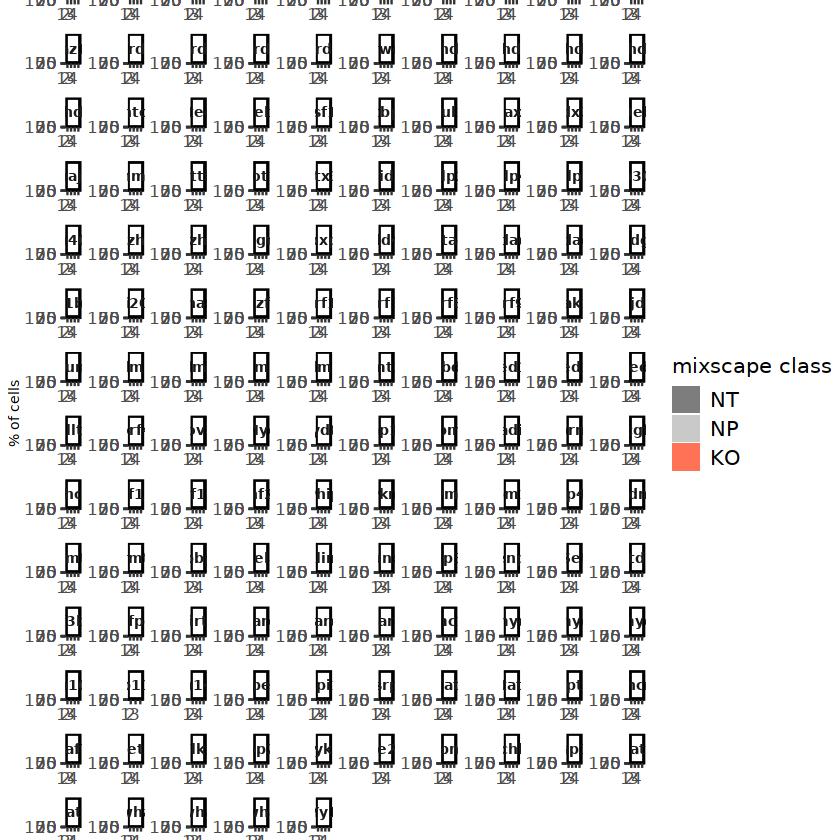

In [28]:
# Calculate percentage of KO cells for all target gene classes.
df <- prop.table(table(KO150$mixscape_class.global, KO150$NT),2)

df2 <- reshape2::melt(df)
df2$Var2 <- as.character(df2$Var2)
test <- df2[which(df2$Var1 == "KO"),]
test <- test[order(test$value, decreasing = T),]
new.levels <- test$Var2
df2$Var2 <- factor(df2$Var2, levels = new.levels )
df2$Var1 <- factor(df2$Var1, levels = c("NT", "NP", "KO"))
df2$gene <- sapply(as.character(df2$Var2), function(x) gsub("g.$", "", x))
df2$guide_number <- sapply(as.character(df2$Var2), 
                           function(x) tail(strsplit(x, split = "g")[[1]],1))
df3 <- df2[-c(which(df2$gene == "NT")),]

p1 <- ggplot(df3, aes(x = guide_number, y = value*100, fill= Var1)) +
  geom_bar(stat= "identity") +
  theme_classic()+
  scale_fill_manual(values = c("grey49", "grey79","coral1")) + 
  ylab("% of cells") +
  xlab("sgRNA")

p1 + theme(axis.text.x = element_text(size = 10, hjust = 1), 
           axis.text.y = element_text(size = 10), 
           axis.title = element_text(size = 8), 
           strip.text = element_text(size=8, face = "bold")) + 
  facet_wrap(vars(gene),ncol = 10, scales = "free") +
  labs(fill = "mixscape class") +theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 12))

ggsave(
  paste0("KO150_","_PercentageKO_all",".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
    height=20,
    width=20
)

In [29]:
# Explore the perturbation scores of cells.
Idents(object = KO150) <- 'mixscape_class'

for (gene in unique(KO150$gene)){
    # skip the gene if NT, only KO or NP cells exist, or one group (KO,NP) have only one cell
    if (gene=="NT" | length(unique(KO150$mixscape_class.global[KO150$gene==gene]))==1 | sum(table(KO150$mixscape_class.global[KO150$gene==gene])==1)>0){
        next
    }
    print(gene)
    PlotPerturbScore(object = KO150,
                     target.gene.ident = gene, 
                     group.by = "mixscape_class", 
                     col = "coral2") + labs(fill = "mixscape class")
    ggsave(
      paste0("KO150_","_PerturbScore_",gene,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

[1] "Smc1a"


Saving 6.67 x 6.67 in image



[1] "Irf9"


Saving 6.67 x 6.67 in image



[1] "Myd88"


Saving 6.67 x 6.67 in image



[1] "Spi1"


Saving 6.67 x 6.67 in image



[1] "Tyk2"


Saving 6.67 x 6.67 in image



[1] "Jak1"


Saving 6.67 x 6.67 in image



[1] "Ifnar1"


Saving 6.67 x 6.67 in image



[1] "Chd4"


Saving 6.67 x 6.67 in image



[1] "Sfpq"


Saving 6.67 x 6.67 in image



[1] "Ep400"


Saving 6.67 x 6.67 in image



In [30]:
# Inspect the posterior probability values in NP and KO cells.
Idents(object = KO150) <- 'mixscape_class'

for (gene in unique(KO150$gene)){
    if (gene=="NT"){
        next
    }

    VlnPlot(KO150, "mixscape_class_p_ko", idents = c("NT", paste0(gene," KO"), paste0(gene," NP"))) +
      theme(axis.text.x = element_text(angle = 0, hjust = 0.5),axis.text = element_text(size = 16) ,plot.title = element_text(size = 20)) + 
      NoLegend() +
      ggtitle("mixscape posterior probabilities")
    
    ggsave(
      paste0("KO150_",'violin',"_PosteriorProbability_",gene, ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of mixscape_class_p_ko.”
Saving 6.67 x 6.67 in image

Warning message in SingleExIPlot(type = type, data = data[, x

In [31]:
# load RNA DEA results per KO, filter for sign. genes (adj.p-value<stat_sign), order by KO porbability, make heatmap
stat_sign <- 0.05
top_n <- 40

Idents(object = KO150) <- "gene"

for (gene in unique(KO150$gene)){
#     print(gene)
    if (gene=="NT"){
        next
    }

    tmp_dea_genes <- read.csv(file=file.path(data_path,'DEA_condition',paste0('KO150_DEA_RNA_',cond,'_',gene,'.csv')), row.names=1)
    sign_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
#     print(sign_genes)
    
    if(length(sign_genes)<1){
        next
    }
    
    if(!(sign_genes %in% rownames(GetAssayData(object = KO150, slot = "scale.data")))){
        next
    }

    # select cells and sort cells by their mixscape KO posterior probability
    cell_names <- names(sort(KO150$mixscape_class_p_ko[colnames(KO150)[KO150$gene==gene|KO150$gene=="NT"]], decreasing=FALSE))
    
    DoHeatmap(KO150, cells=cell_names, group.by="mixscape_class", features = sign_genes[1:top_n])
    
    ggsave(
      paste0("KO150_",'Heatmap',"_DEA_RNA_",gene,"_top",top_n,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT149, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the scale.data slot for the PRTB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT149, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (!(sign_genes %in% rownames(GetAssayData(object = PT149, slot = "scale.data")))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the scale.data slot for the PRTB assay: NA, Fth1, Ppt2, Cpne1, Polr2a, Rida, Gm10785”
Saving 6.6

In [32]:
# load AB DEA results per KO, filter for sign. genes (adj.p-value<stat_sign), order by KO porbability, make heatmap
stat_sign <- 0.05
top_n <- 40

Idents(object = KO150) <- "gene"

for (gene in unique(KO150$gene)){
#     print(gene)
    if (gene=="NT"){
        next
    }
    
    tmp_dea_genes <- read.csv(file=file.path(data_path,'DEA_condition',paste0('KO150_DEA_AB_',cond,'_',gene,'.csv')), row.names=1)
    sign_genes <- rownames(tmp_dea_genes)[tmp_dea_genes$p_val_adj<stat_sign]
#     print(sign_genes)
    
    if(length(sign_genes)<1){
        next
    }
    
#     if(!(sign_genes %in% rownames(GetAssayData(object = PT141, slot = "scale.data")))){
#         next
#     }

    # select cells and sort cells by their mixscape KO posterior probability
    cell_names <- names(sort(KO150$mixscape_class_p_ko[colnames(KO150)[KO150$gene==gene|KO150$gene=="NT"]], decreasing=FALSE))
    
    DoHeatmap(KO150, cells=cell_names, group.by="mixscape_class", features = sign_genes[1:top_n], assay="AB", slot="data")
    
    ggsave(
      paste0("KO150_",'Heatmap',"_DEA_AB_",gene,"_top",top_n,".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
    )
}

Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not found in the data slot for the AB assay: NA”
Saving 6.67 x 6.67 in image

Warning message in DoHeatmap(PT149, cells = cell_names, group.by = "mixscape_class", :
“The following features were omitted as they were not

In [33]:
# Protein expression pathways
Idents(object = KO150) <- "gene"

DefaultAssay(object = KO150)<-'AB'
ABs <- rownames(KO150)
DefaultAssay(object = KO150)<-'PRTB'

genes_reordered <- c("NT", unique(KO150$gene)[!(unique(KO150$gene) %in% c('NT'))])

for (AB in ABs){
    VlnPlot(
      object = KO150, 
      features = paste0("ab_",AB), 
      idents = genes_reordered, # has no effect
      group.by = "gene", 
      pt.size = 0.2, 
      sort = T, 
      split.by = "mixscape_class.global", 
      cols = c("coral3","grey79","grey39")) +
      ggtitle(paste0(AB," protein")) +
      theme(axis.text.x = element_text(angle = 90, hjust = 0.95, vjust=0.2), plot.title = element_text(size = 10), axis.text = element_text(size = 10))
    
        ggsave(
      paste0("KO150_",'violin_protein_',AB, ".svg"),
      plot = last_plot(),
      device = "svg",
      path = file.path(results_path),
      scale = 1,
      dpi = 300,
      limitsize = FALSE,
            width=20
    )
    
}

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image

Saving 20 x 6.67 in image



### Unsupervised analysis of PRTB perturbed cells

In [34]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO150) <- "mixscape_class.global"
sub_test <- subset(KO150, idents = c("KO", "NT"))
sub_test

An object of class Seurat 
33838 features across 880 samples within 5 assays 
Active assay: PRTB (2165 features, 0 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 4 dimensional reductions calculated: pca, umap, prtbpca, prtbumap

In [35]:
DefaultAssay(object = sub_test)

[1] "PRTB"

In [36]:
DefaultAssay(object = sub_test) <- 'RNA'
sub_test <- NormalizeData(object = sub_test) %>% FindVariableFeatures() %>% ScaleData()
# Prepare PRTB assay for dimensionality reduction: 
# Normalize data, find variable features and center data.
DefaultAssay(object = sub_test) <- 'PRTB'

# Use variable features from RNA assay.
VariableFeatures(object = sub_test) <- VariableFeatures(object = sub_test[["RNA"]])
sub_test <- ScaleData(object = sub_test, do.scale = F, do.center = T)

Centering and scaling data matrix

Warning message:
“Not all features provided are in this Assay object, removing the following feature(s): Ptpre, AI838599, AC117662.4, Klhdc7a, Antxr1, Gtf2a1, Gm17092, Gm15853, Zfp296, Efcc1, Fam26f, Lamc2, Gm5149, Gm10501, Dpp7, Tubb6, Fam178b, Cenpu, Gm16587, Gpc1, Aldh1b1, Il2rb, Samd8, Calml4, Erh, Gm20443, Cenps, Gm14009, Gm10655, St5, Gm39459, Gm20708, Hist1h2ac, Ly86, Sod1, Ttll11, Bmp1, Bard1, Tpm2, Clec1a, Rasd1, AL589670.3, Ccdc85b, Mtap, Rep15, Psen2, Bbs9, F9, Tfr2, Olfr461, Nyap1, Gm7008, Fus, Hist1h3i, Trim62, Itgb4, Hecw2, Acot2, Sh3pxd2a, Batf2, Treml4, Pls3, Nfkbid, Ipo7, Faah, mt-Nd1, Uap1l1, Gnl3, Zgrf1, Rps6ka2, Mnd1, 4833407H14Rik, Irf5, Arid5a, Cenpj, Siva1, Trim69, Gm15935, Rab39, Lima1, Gfod2, Sesn2, Edem1, Syncrip, Dnm3, Gpm6b, Zfp979, Gm43409, Cd79a, Ccdc38, Gm31805, AC114585.1, Hephl1, Osbpl10, Scn10a, Hist1h3d, A830082K12Rik, Gpr22, Rimbp3, Rbm11, Olfr110, AI661453, Pcdh1, Oas1e, Grid1, Gm49293, Gpr62, Slc16a12, Ncbp2, Plxn

In [37]:
# Run PCA to reduce the dimensionality of the data.
sub_test <- RunPCA(object = sub_test, reduction.key = 'prtbpca', reduction.name = 'prtbpca')

# Run UMAP to visualize clustering in 2-D.
sub_test <- RunUMAP(
  object = sub_test, 
  dims = 1:40, 
  reduction = 'prtbpca', 
  reduction.key = 'prtbumap', 
  reduction.name = 'prtbumap')

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from prtbpca to prtbpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to prtbpca_”
prtbpca_ 1 
Positive:  Cxcl2, Mt1, mt-Co2, Ccl2, Wfdc17, Ccl7, Tmsb4x, mt-Cytb, Lyz2, Phlda1 
	   Hmox1, Odc1, Btg1, Cd9, Vim, Spp1, Hilpda, Cd36, Ier3, Plk2 
	   Cited2, P4hb, Mt2, Prdx1, Fam162a, Ahnak, S100a6, Alox5ap, Id2, Cd44 
Negative:  Irf7, Isg15, Ly6e, Ifi27l2a, Rsad2, Usp18, Slfn4, Xaf1, Lgals9, Isg20 
	   Phf11d, Ifit2, Oasl1, Ifi202b, Rtp4, Zbp1, Ifi44, Npc2, Slfn2, Ifit1 
	   H2-T22, Epsti1, Ifit3, Sp100, Mndal, Cxcl10, Ifi207, Ccl5, Oasl2, Lgals3bp 
prtbpca_ 2 
Positive:  Ccl2, Csf3, Cxcl2, Spp1, Ccl4, Phlda1, Ccl9, Ptgs2, Wfdc17, Tnf 
	   Ier3, Hmox1, Ccl7, Plk2, Clec4e, Odc1, Rgs1, Acod1, Cd14, Atf3 
	   Rsbn1, Hilpda, Socs3, Plin2, Zfp36, Glrx, Metrnl, Dusp1, Msr1, Vim 
Negative:  Slpi, Ccl5, S100a11, Gm42418,

Saving 6.67 x 6.67 in image



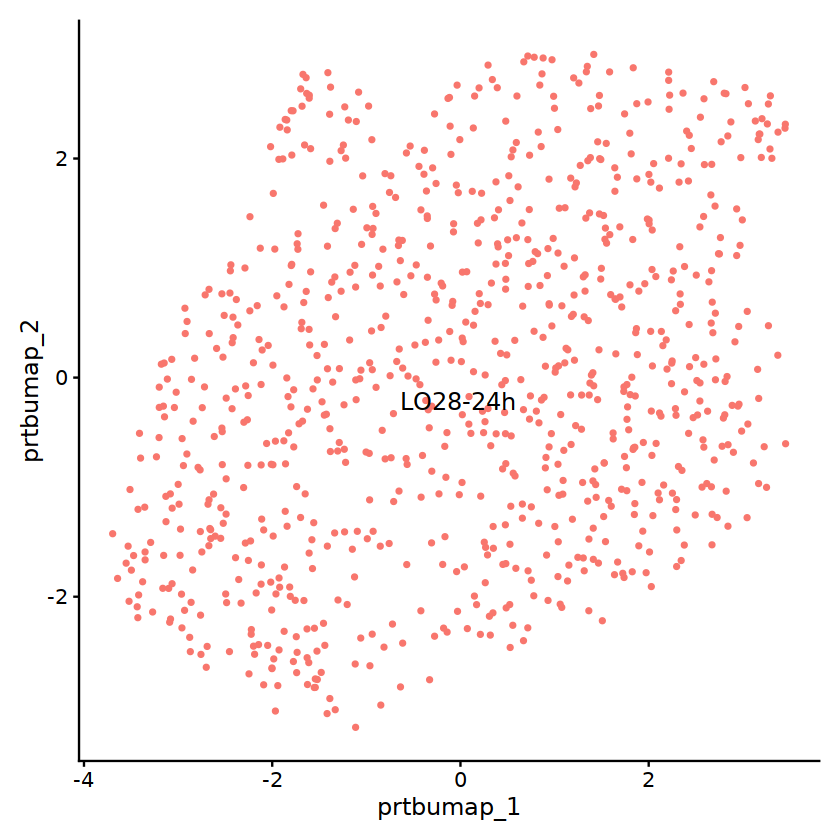

In [38]:
Idents(sub_test) <- "condition"

DimPlot(object = sub_test,
             reduction = "prtbumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO150_",'UMAP_PRTB_condition', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



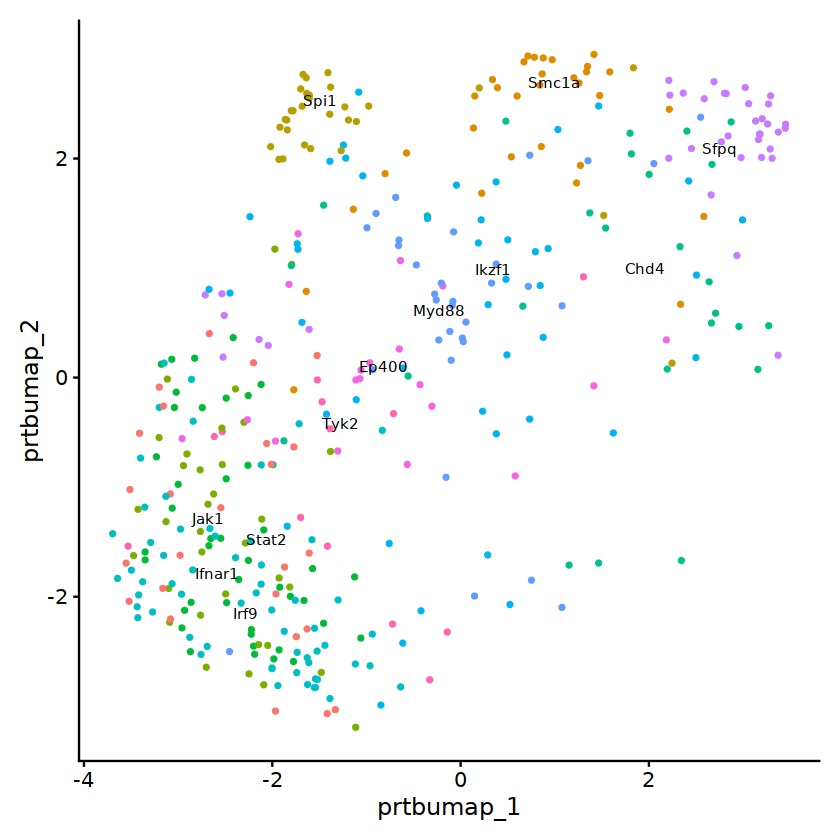

In [39]:
Idents(sub_test) <- "gene"

DimPlot(object = sub_test,
        cells=colnames(sub_test)[sub_test$mixscape_class!='NT'],
             reduction = "prtbumap", 
             repel = T, 
             label.size = 3, 
             label = T, 
#              cols = col
            ) + NoLegend()

ggsave(
  paste0("KO150_",'UMAP_PRTB_condition_KO', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

### LDA of PRTB perturbed & NT cells

In [40]:
# Remove non-perturbed cells and run LDA to reduce the dimensionality of the data.
Idents(KO150) <- "mixscape_class.global"
sub <- subset(KO150, idents = c("KO", "NT"))

In [41]:
# Run LDA.
sub <- MixscapeLDA(
  object = sub, 
  assay = "RNA", 
  pc.assay = "PRTB", 
  labels = "gene", 
  nt.label = "NT", 
  npcs = 10, 
  logfc.threshold = 0.25, 
  verbose = F)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [42]:
# Use LDA results to run UMAP and visualize cells on 2-D. 
# Here, we note that the number of the dimensions to be used is equal to the number of 
# labels minus one (to account for NT cells).
sub <- RunUMAP(
  object = sub,
  dims = 1:(length(unique(sub$mixscape_class))-1),
  reduction = 'lda',
  reduction.key = 'ldaumap',
  reduction.name = 'ldaumap')

12:26:06 UMAP embedding parameters a = 0.9922 b = 1.112

12:26:06 Read 880 rows and found 12 numeric columns

12:26:06 Using Annoy for neighbor search, n_neighbors = 30

12:26:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:26:06 Writing NN index file to temp file /home/sreichl/tmp//RtmpxLabGe/file443e43fea740

12:26:06 Searching Annoy index using 1 thread, search_k = 3000

12:26:06 Annoy recall = 100%

12:26:07 Commencing smooth kNN distance calibration using 1 thread

12:26:08 Initializing from normalized Laplacian + noise

12:26:08 Commencing optimization for 500 epochs, with 32392 positive edges

12:26:13 Optimization finished

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ldaumap to ldaumap_”

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



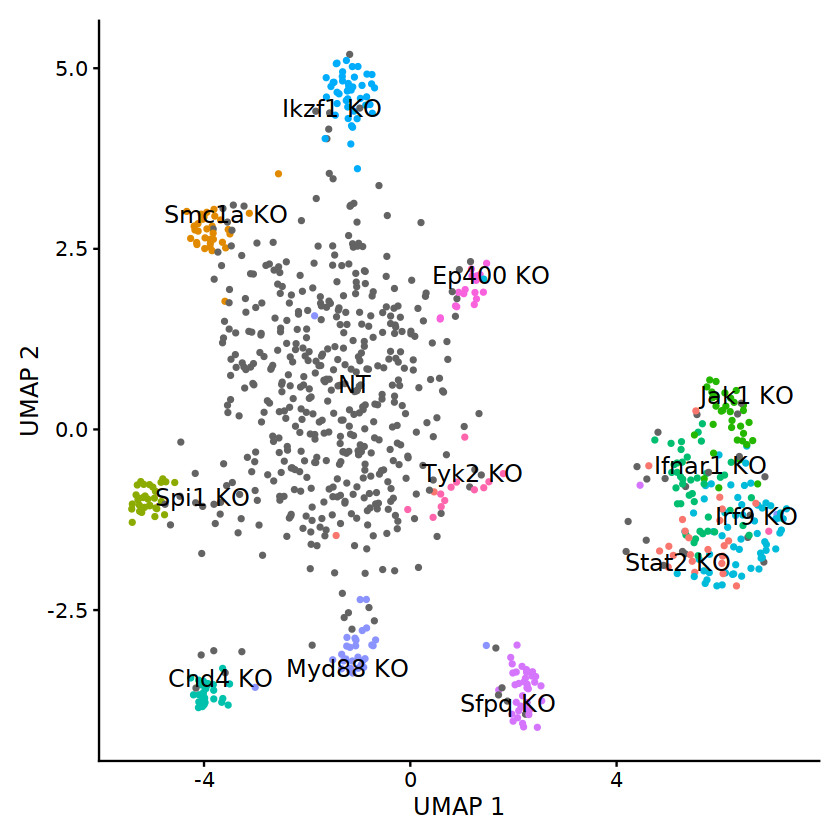

In [43]:
# Visualize UMAP clustering results.
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Saving 6.67 x 6.67 in image



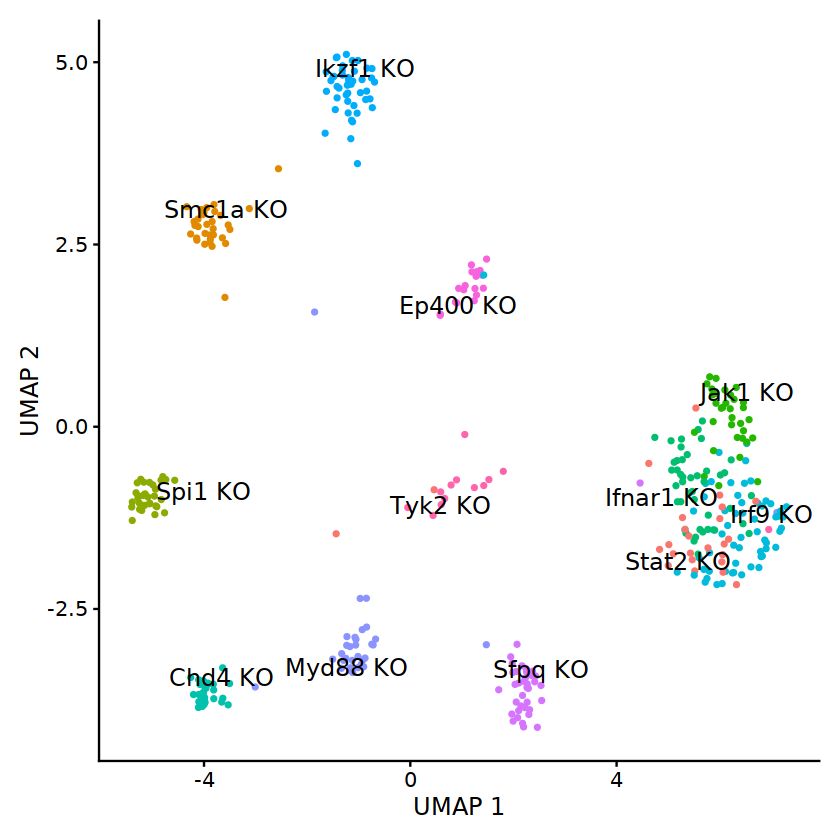

In [44]:
# Visualize UMAP clustering results without NT cells
Idents(sub) <- "mixscape_class"
sub$mixscape_class <- as.factor(sub$mixscape_class)

# Set colors for each perturbation.
col = setNames(object = hue_pal()(length(unique(sub$mixscape_class))),nm = unique(sub$mixscape_class))
# names(col) <- c(names(col)[1:7], "NT", names(col)[9:12])
col["NT"] <- "grey39"

p <- DimPlot(object = sub, 
             cells=colnames(sub)[sub$mixscape_class!='NT'],
             reduction = "ldaumap", 
             repel = T, 
             label.size = 5, 
             label = T, 
             cols = col) + NoLegend()

p2 <- p+ 
  scale_color_manual(values=col, drop=FALSE) + 
  ylab("UMAP 2") +
  xlab("UMAP 1") +
  custom_theme
p2

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_','pure', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

Saving 6.67 x 6.67 in image



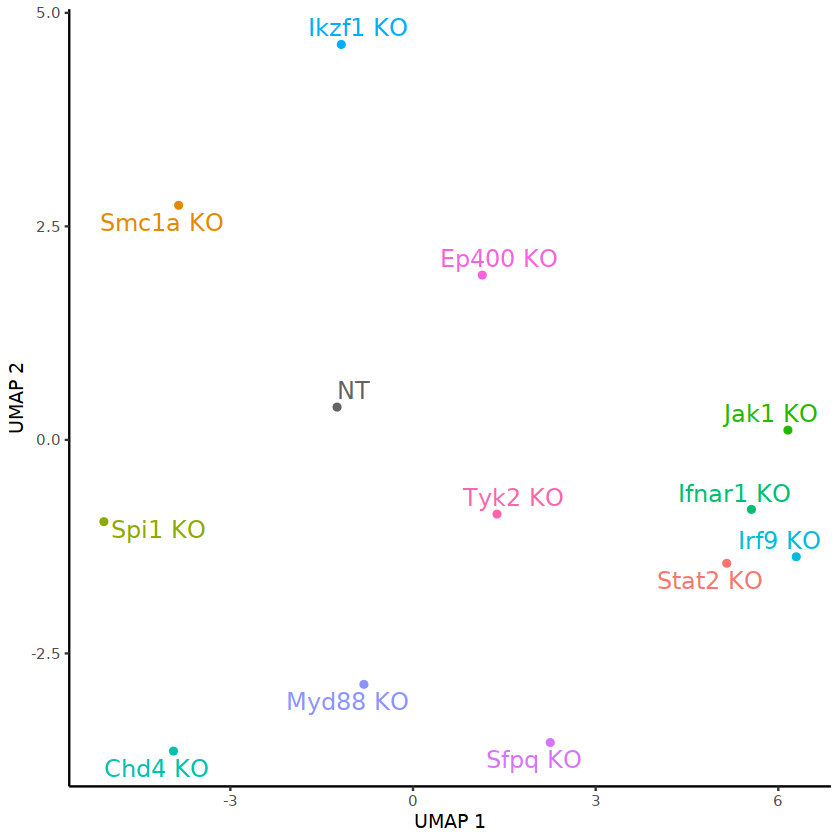

In [45]:
# plot only the centroids
ldaumap_data <- Embeddings(object = sub, reduction = "ldaumap")
ldaumap_data <- data.frame(ldaumap_data)
ldaumap_data$mixscape_class <- sub$mixscape_class[rownames(ldaumap_data)]

ldaumap_means <- aggregate(ldaumap_data[, c('ldaumap_1','ldaumap_2')], list(ldaumap_data$mixscape_class), mean)

p <- ggplot(ldaumap_means, aes(ldaumap_1, ldaumap_2, colour = Group.1)) + 
    geom_point()  + 
    geom_text_repel(aes(label=Group.1), size = 5)

p1 <-  p+ 
    scale_color_manual(values=col, drop=FALSE) +
    ylab("UMAP 2") +
    xlab("UMAP 1") +
    theme_classic()+ 
    NoLegend()

p1

ggsave(
  paste0("KO150_",'UMAP_LDA_KO_','centroids', ".svg"),
  plot = last_plot(),
  device = "svg",
  path = file.path(results_path),
  scale = 1,
  dpi = 300,
  limitsize = FALSE,
)

In [46]:
# save Seurat object
saveRDS(sub, file = file.path(results_path,paste0("KO150_mixscape_subset_Seurat.rds")))

In [60]:
# loading Seurat object
sub <-readRDS(file = file.path(results_path,paste0("KO150_mixscape_subset_Seurat.rds")))
sub

An object of class Seurat 
33947 features across 2485 samples within 5 assays 
Active assay: PRTB (2274 features, 2000 variable features)
 4 other assays present: RNA, AB, gRNA, HTO
 6 dimensional reductions calculated: pca, umap, prtbpca, prtbumap, lda, ldaumap